### 1. Settings 

In [4]:
import warnings
warnings.filterwarnings("ignore")
import os,pickle,sys,re,glob
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import RepeatedStratifiedKFold
from IPython.display import Image
from venn import venn
from importlib import reload
#customized module
from fun import network_analysis, predictive_model, validation
from fun import utilities as ut
%matplotlib inline

cwd = os.getcwd()
datapath=cwd+'/../working-folder'
outputpath=cwd+'/data'
#normalized gene expression data
nor_exp_data=datapath+'/normalized-data'
#Create directory to store the *pooled* differential gene expression data
pooled_diff_gene_exp_data=datapath+'/diff-gene-expression-matrix'
#Create directory to store edge weight distribution
edge_distr_data_dir = datapath+'/edge-distribution'
#Create directory to store null edge weight distribution
null_distr_data_dir = datapath+'/null-distribution'
pickled_objects_dir = datapath+'/pickled-files'
#data to be shared in the publication
publication_dir=outputpath

#Training model disectory
currentversion='opt_score_rocauc'
MLsearch=pickled_objects_dir+'/ML-param-search/'+currentversion
random_state=1#for creating randomized model
cpu=60 #cpu=-1 use all processors
#For coding, if necessary
reload(predictive_model);reload(ut)
gAssem=network_analysis.geneAssemClass(cwd,datapath,outputpath)
gpmod=predictive_model.predModelClass(cwd,datapath,outputpath,pickled_objects_dir,random_state,cpu)

### 2. Load and process meta-data (gene expression data and pre-defined geneset from the network analysis)

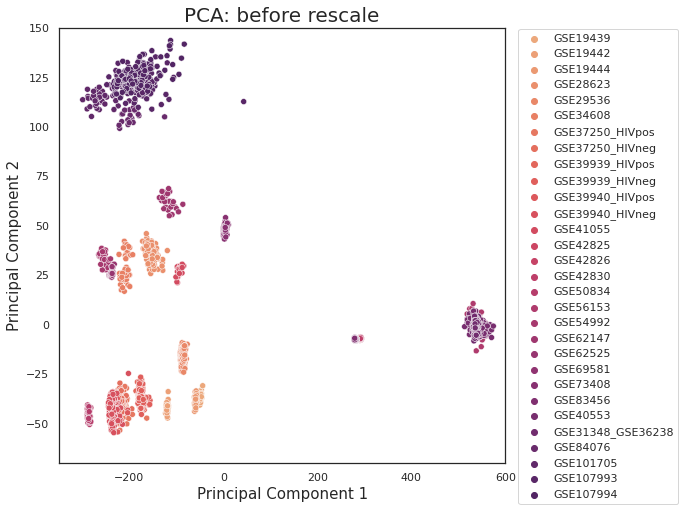

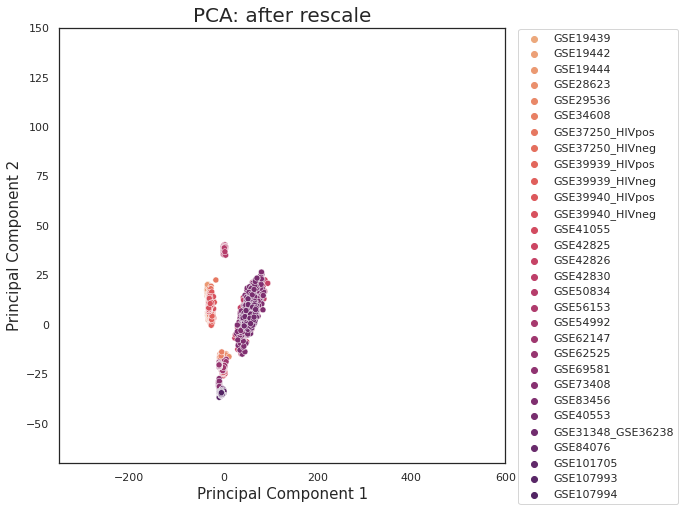

In [5]:
#Expression data for all the datasets used for model training.
#Return rescaled X (mean=0 and variance =1)
X,Y=gpmod.TBexpressiondata(nor_exp_data)

In [6]:
#Geneset determined from the network analysis
with open(pickled_objects_dir+'/network-gene-select/gene_series_rule3.pickle', 'rb') as handle:
    geneset = pickle.load(handle)

#Remove genes not included in >80% of the traning datasets  
geneset=ut.intersection(geneset,X.index)
#Remove samples with more than 1 missing values
fX=X.loc[geneset,X.loc[geneset,:].isnull().sum()<2]
fY=Y.loc[fX.columns,:]
#Convert status to numeric group
fY['group'] = fY['Status'].apply(gpmod.scaleStatusOutcome)
#Recover the missing value
fX=ut.MissingValueRecovery(fX)

### 3. Generate paired gene features 
- To ensure the predictive model suitable for different platforms (RNAseq, microarray, RT-PCR), we use gene expression ratio as the feaures for model training. 
- Since the expression take log before doing zscore, substraction between any gene pair, instead of division will be calculated for feature generation. 


In [7]:
#Generate paired gene features
pairfX=gpmod.feaCombo(fX.T,pickled_objects_dir,approach=2)

### 4. Build a predictive model under a nested cross-validation framework

#### Build a predictive model from ATB vs (HC, LTBI and OD) --combine
- The model is considered to identify gene signature to classify TB (ATB) versus non-TB (HC, LTBI and non-TB)

In [21]:
#Use StratifiedKFold to preserve the class distribution of the dataset in the splits.
inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=random_state)
outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=random_state)#To be efficient, only one repeat for outer CV

pat=fY.index[(fY['Status']=='ATB')|(fY['Status']=='HC')|(fY['Status']=='LTBI')|(fY['Status']=='OD')]
sub_pairfX=pairfX.loc[pat]
sub_fY=fY.loc[pat,'group']

Sfea_comb, benchm_model_comb = gpmod.ML_CV_param_search_framework(
    sub_pairfX, sub_fY, inner_cv, outer_cv,currentversion+'/ATB_nonATB_combine','ATB vs non ATB (combine): Cross-validation ROC',randomCV_n_itr=250)
   
benchm_model_comb.to_csv(MLsearch+'/ml_benchmark_geneset_combine.csv',index=True)
with open(MLsearch+'/geneset-used-in-cv-model-combine.pickle' , 'wb') as handle:           
    pickle.dump(Sfea_comb, handle, protocol=pickle.HIGHEST_PROTOCOL) 

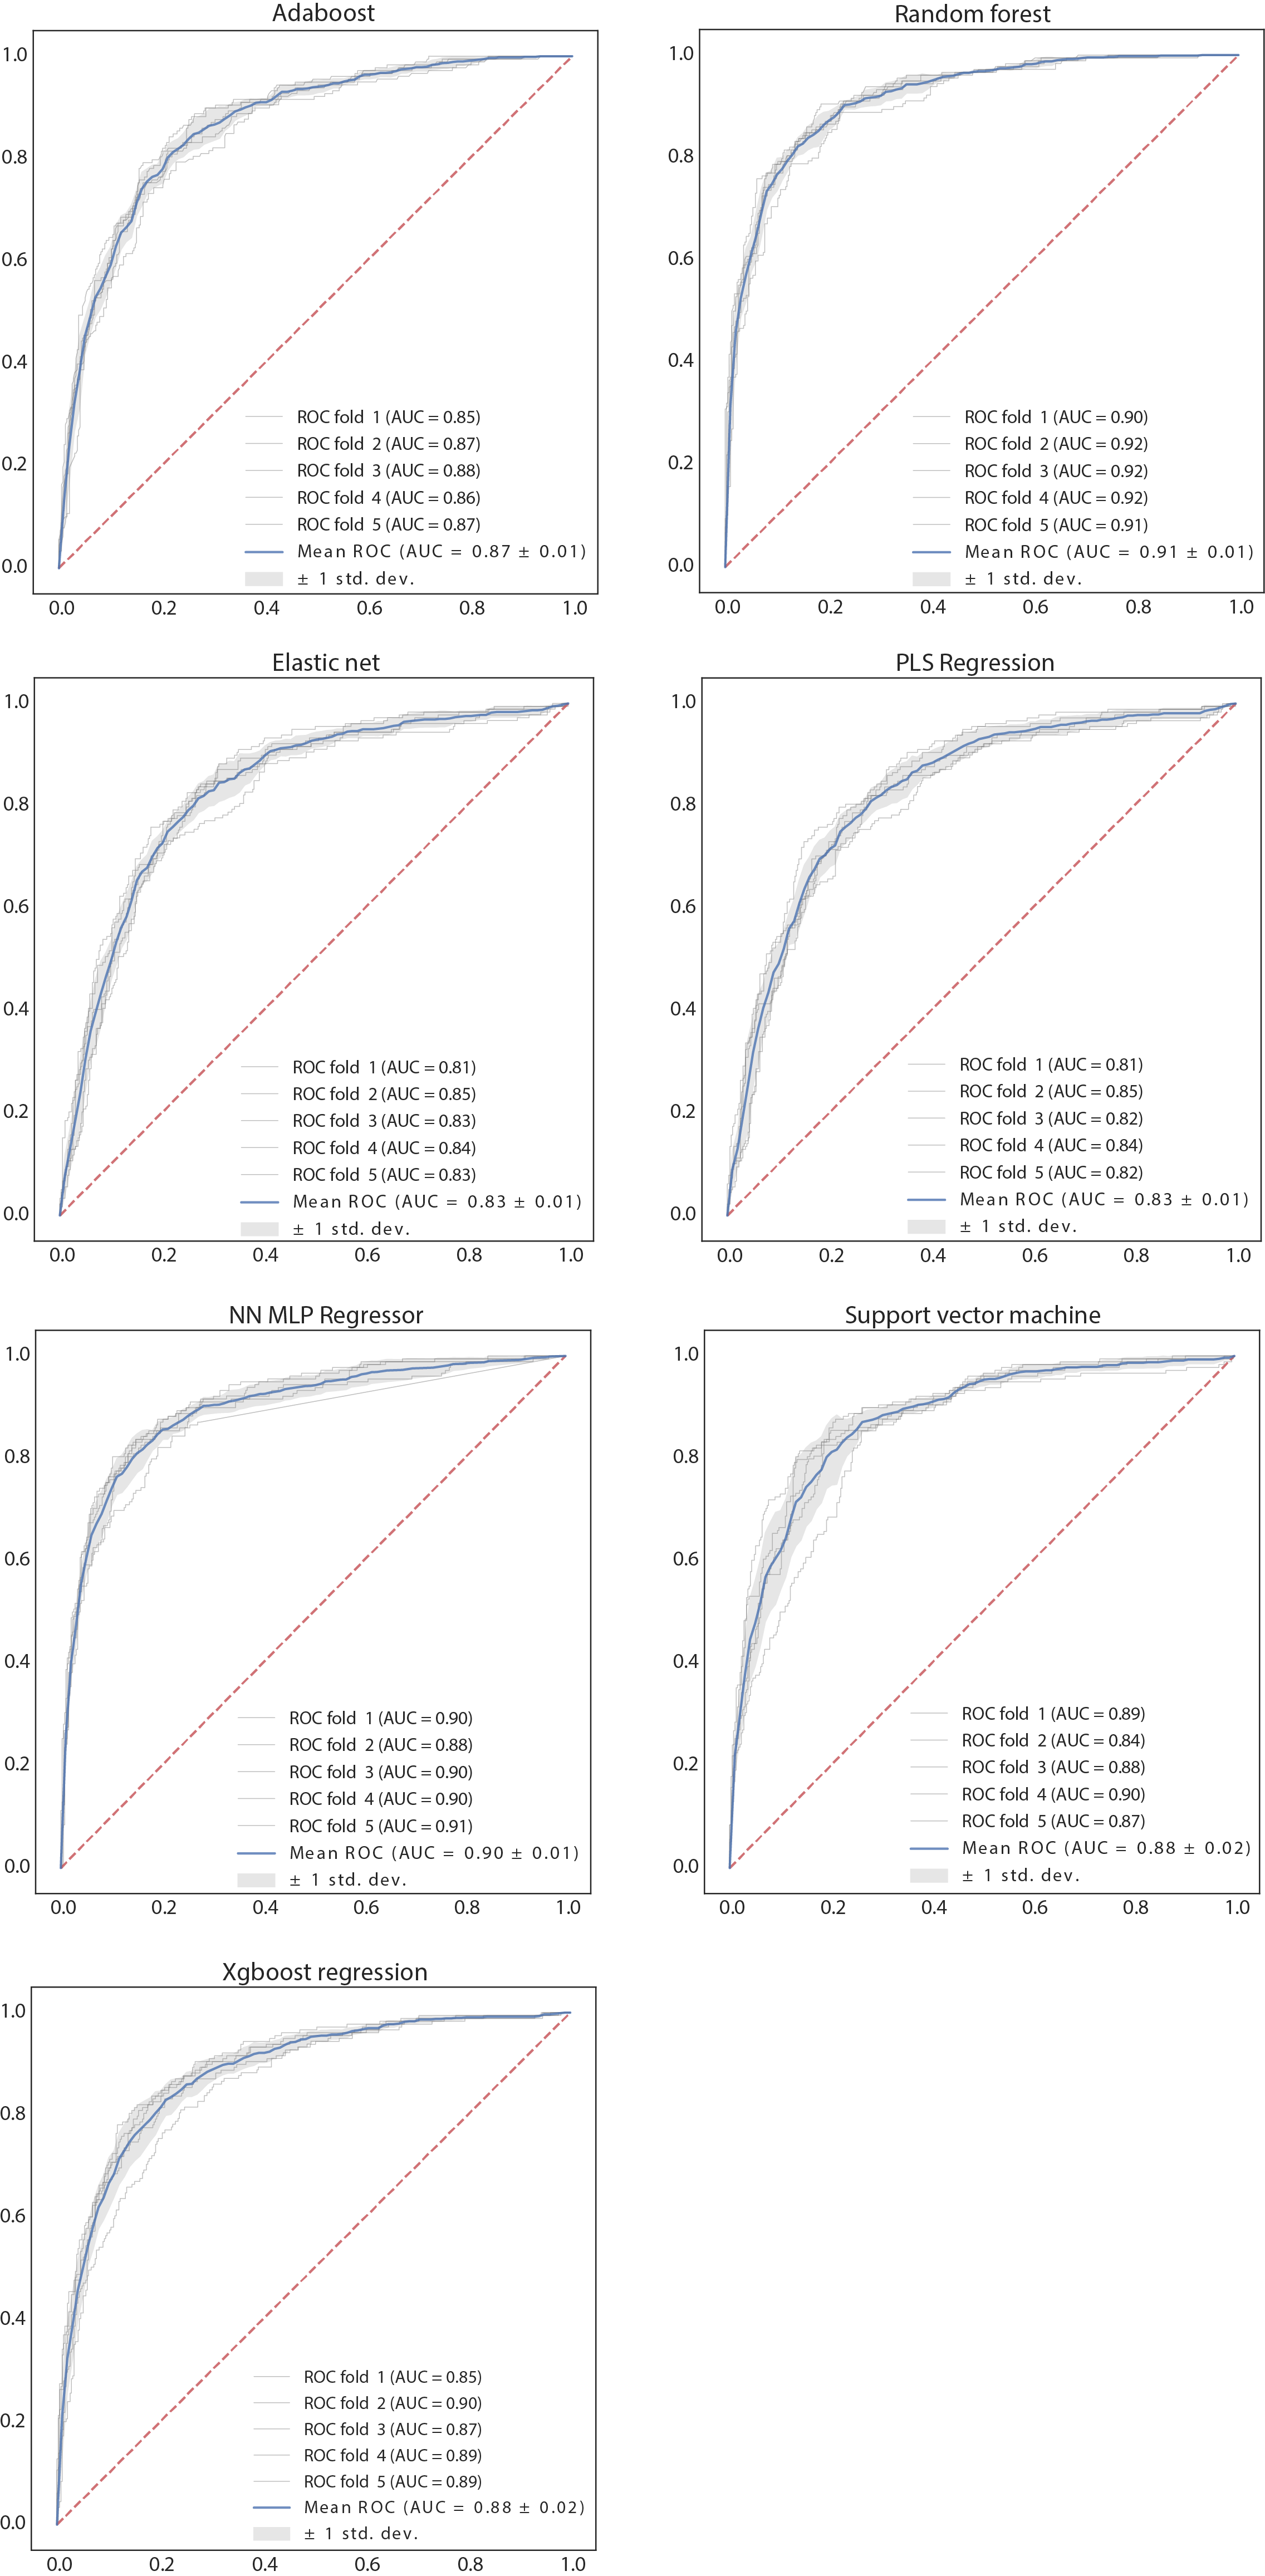

In [22]:
Image("../working-folder/pickled-files/ML-param-search/opt_score_rocauc/ML_selection_CV_evaluation_progression.png", width=800, height=1200)

#### 4. Evaluate the model with minimize features 

In [23]:
for ml in ['random_forest']:
    pat=fY.index[(fY['Status']=='ATB')|(fY['Status']=='HC')|(fY['Status']=='LTBI')|(fY['Status']=='OD')]
    sub_pairfX=pairfX.loc[pat]
    sub_fY=fY.loc[pat,'group']
    Sfea_comb, benchm_model_comb = gpmod.ML_CV_param_search_framework_minFea(
        ml, sub_pairfX, sub_fY, inner_cv, outer_cv,currentversion+'/ATB_nonATB_combine',ml+' combine:',randomCV_n_itr=250)

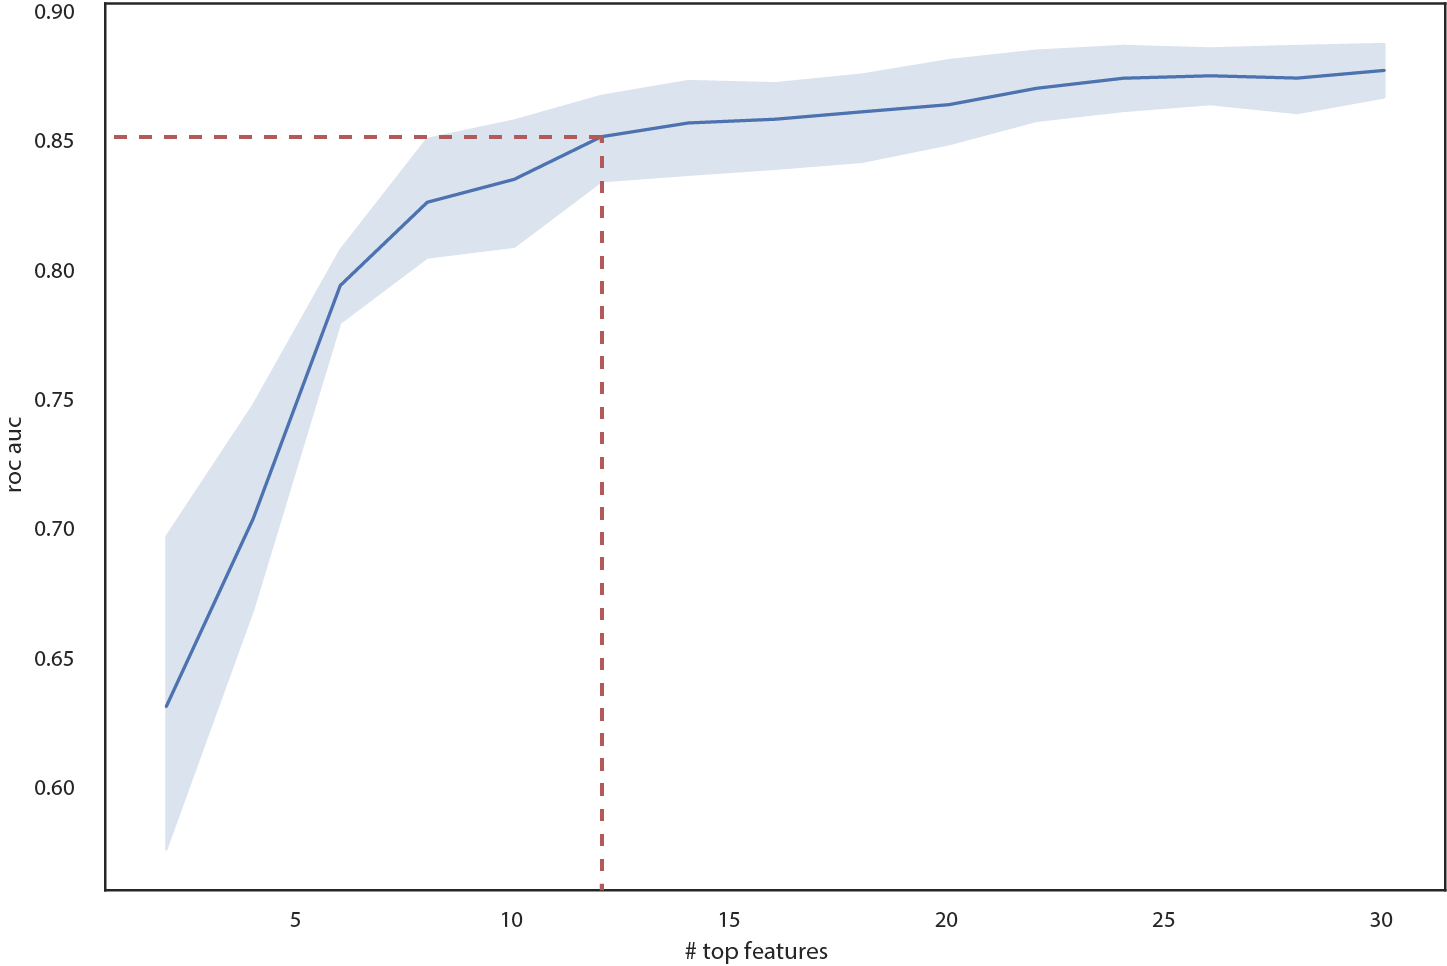

In [25]:
Image("../working-folder/pickled-files/ML-param-search/opt_score_rocauc/Downselect_Fea_Progression_model_RF.png", width=800, height=800)

### Build the final model by using all the training dataset
#### The full model 
###### Consider all necessary features to reach the best predictive performance

In [26]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_state)
summary=[]
select_ml='random_forest'
fs=2

pat=fY.index[(fY['Status']=='ATB')|(fY['Status']=='HC')|(fY['Status']=='LTBI')|(fY['Status']=='OD')]
sub_pairfX=pairfX.loc[pat]
sub_fY=fY.loc[pat,'group']
select_fea, final_model, inner_cv_score, scorer, _=gpmod.build_finalmodel(sub_pairfX, sub_fY, select_ml, fs, cv)
print('fs'+str(fs)+':'+select_ml+'|inner_cv_'+scorer+'='+str(inner_cv_score))
#save model
with open(pickled_objects_dir+'/final-ML-model/'+currentversion+'/ATB_nonATB_combine_fs_'+str(fs)+'_'+select_ml+'.pickle' , 'wb') as handle:           
    pickle.dump([select_fea,final_model,select_ml], handle, protocol=pickle.HIGHEST_PROTOCOL) 
summary.append(['ATB_nonATB_combine', fs, select_ml, len(select_fea), inner_cv_score, final_model, ','.join(select_fea)])

summarTyT=pd.DataFrame(summary,columns=['Group type','Fea selection type','ML type','# features','inner_cv_'+scorer,'parameters','features'])
summarTyT.to_csv(pickled_objects_dir+'/final-ML-model/'+currentversion+'/final_model_summary.csv',index=True)

#### The reduced model 
###### Consider the minimized number of features to have a comparable predictive performance

In [27]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_state)
topfeaN=dict()
topfeaN['random_forest']={'Combine':12}
fs=3

for select_ml in ['random_forest']:
    summary=[]
    pat=fY.index[(fY['Status']=='ATB')|(fY['Status']=='HC')|(fY['Status']=='LTBI')|(fY['Status']=='OD')]
    sub_pairfX=pairfX.loc[pat]
    sub_fY=fY.loc[pat,'group']
    topN=topfeaN[select_ml]['Combine']
    #build final model
    select_fea, final_model, inner_cv_score, scorer, fea_rank=gpmod.build_finalmodel(sub_pairfX, sub_fY, select_ml, fs, cv, topN=topN)
    print('fs'+str(fs)+':'+select_ml+'|inner_cv_'+scorer+'='+str(inner_cv_score))
    #save model
    with open(pickled_objects_dir+'/final-ML-model/'+currentversion+'/ATB_nonATB_combine_fs_'+str(fs)+'_'+select_ml+'.pickle' , 'wb') as handle:           
        pickle.dump([select_fea,final_model,select_ml], handle, protocol=pickle.HIGHEST_PROTOCOL) 
    summary.append(['ATB_nonATB_combine', fs, select_ml, len(select_fea), inner_cv_score, final_model, ','.join(select_fea)])
    
    summarTyT=pd.DataFrame(summary,columns=['Group type','Fea selection type','ML type','# features','inner_cv_'+scorer,'parameters','features'])
    original = pd.read_csv(pickled_objects_dir+'/final-ML-model/'+currentversion+'/final_model_summary.csv',sep=',',index_col=0)
    summarTyT= pd.concat([original,summarTyT])
    summarTyT.to_csv(pickled_objects_dir+'/final-ML-model/'+currentversion+'/final_model_summary.csv',index=True)